# Qibolab v0.1.6 1Q emulator demo for QuTiP backend

Results updated on: 04 Apr 2024

## Example 0: Emulator Setup

In [1]:
import pathlib, os, sys
emulator_folder = pathlib.Path(os.path.abspath('')).parent/'tests/emulators/'
sys.path.append(emulator_folder.as_posix())

from default_q0 import create

emulator_platform = create()
pulse_simulator = emulator_platform.instruments['pulse_simulator']
simulation_backend = pulse_simulator.simulation_backend

INFO:root:ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend
INFO:root:emulator qubits: ['0']
INFO:root:emulator couplers: []
INFO:root:runcard qubits: [0]
INFO:root:runcard couplers: []
INFO:root:sampling rate: 4.5GHz
INFO:root:simulation sampling boost: 10
[Qibo 0.2.6|INFO|2024-04-05 01:01:04]: Loading platform ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend
INFO:qibo.config:Loading platform ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend


Hilbert space structure:  ['0']
Hilbert space dimensions:  [3]


In [2]:
from qibolab.instruments.emulator.backends.generic import print_Hamiltonian

print_Hamiltonian(simulation_backend.model_config)

Dictionary


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



---------------------
One-body drift terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Two-body drift terms:
---------------------
None
---------------------
One-body drive terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Dissipative terms:
---------------------
>> t1 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

>> t2 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------


## Example 1: Simulation of Pulse Sequence

### Preparation: Construct Pulse Sequence

PulseSequence
DrivePulse(0, 35.55555555555556, 0.240451, 5_090_167_234.445013, 0, Drag(4, 2.43058), drive-0, 0)
ReadoutPulse(37.77777777777778, 4977.777777777777, 0.03, 7_301_661_824.000001, 0, Rectangular(), readout-0, 0)


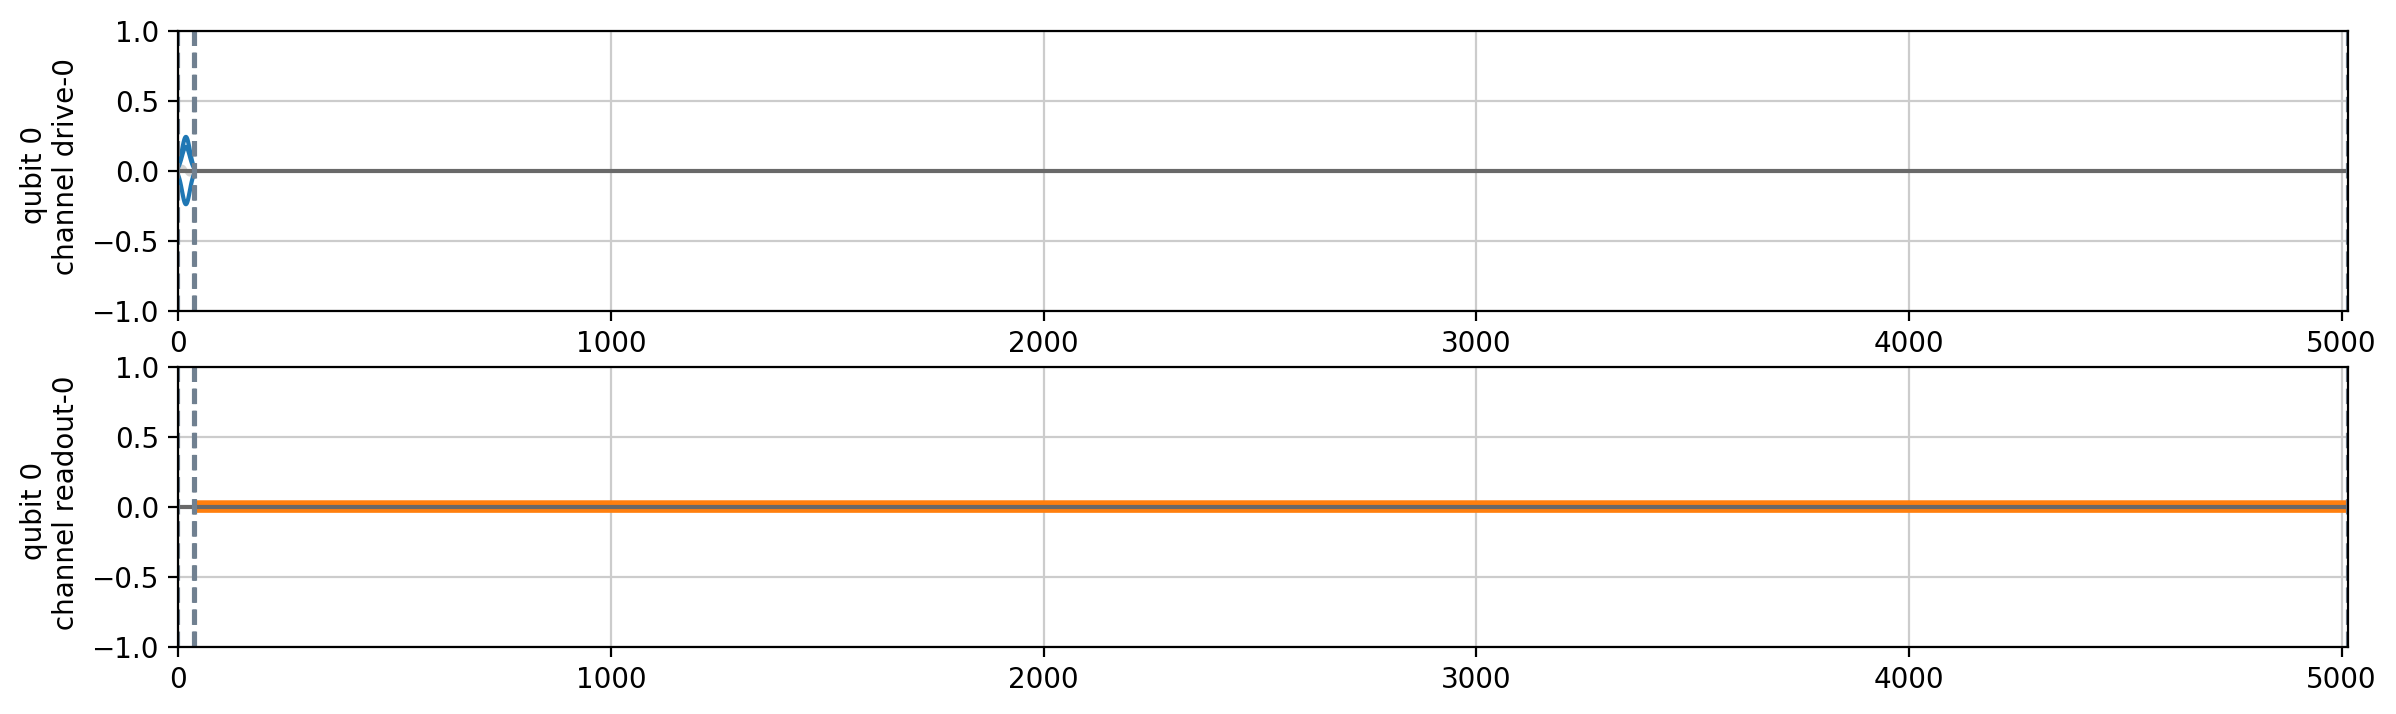

5015.555555555555
37.77777777777778
4977.777777777777


In [3]:
from qibolab.pulses import (
    DrivePulse,
    ReadoutPulse,
    PulseSequence,
    Rectangular,
    Gaussian,
    Drag
)

# Define PulseSequence
sequence = PulseSequence()

# Add some pulses to the pulse sequence
'''
pulse_x0 = DrivePulse(
    start=0,
    frequency=5_090_167_234.445013,
    amplitude=0.240451, 
    duration=35.55555555555556, 
    relative_phase=0,
    shape=Drag(4, 2.43058),
    channel='drive-0',
    qubit=0,
    )
    
pulse_r0 = ReadoutPulse(
    start=10/4.5+x0_pulse.duration,
    frequency=1_622_591_516, 
    amplitude=0.03, 
    duration=10/4.5,
    relative_phase=0,
    shape=Rectangular(),
    channel='readout-0',
    qubit=0,
    )
'''
pulse_x0 = emulator_platform.create_RX_pulse(qubit=0, start=0)
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=(170/4.5))

sequence = PulseSequence()
sequence.add(pulse_x0)
sequence.add(pulse_r0)

print(sequence)
sequence.plot()
print(sequence.duration)
print(pulse_r0.start)
print(pulse_r0.duration)

### Execution: Emulator Pulse and Generate Pulse Sequence

In [4]:
from qibolab.execution_parameters import ExecutionParameters

# Connects to lab instruments using the details specified in the calibration settings.
emulator_platform.instruments['pulse_simulator'].connect()

# Configures instruments using the loaded calibration settings.
emulator_platform.instruments['pulse_simulator'].setup()

# Turns on the local oscillators
emulator_platform.instruments['pulse_simulator'].start()

# Turn off readout error
emulator_platform.instruments['pulse_simulator'].readout_error = None

# Executes a pulse sequence.
options = ExecutionParameters(nshots=1000)#, relaxation_time=100)
results = emulator_platform.execute_pulse_sequence(sequence, options=options)
#results = pulse_simulator.play({0:0}, {}, sequence, options=options)

# Turn off lab instruments
emulator_platform.instruments['pulse_simulator'].stop()

# Disconnect from the instruments
emulator_platform.instruments['pulse_simulator'].disconnect()

emulator_platform.instruments['pulse_simulator'].print_sim_details()

[Qibo 0.2.6|INFO|2024-04-05 01:01:04]: Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
INFO:qibo.config:Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
[Qibo 0.2.6|INFO|2024-04-05 01:01:04]: Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
INFO:qibo.config:Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
[Qibo 0.2.6|INFO|2024-04-05 01:01:04]: Starting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
INFO:qibo.config:Starting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
[Qibo 0.2.6|INFO|2024-04-05 01:01:04]: Minimal execution time (sequence): 0.3050155555555556
INFO:qibo.config:Minimal execution time (sequence): 0.3050155555555556


 Total run time:   1.40s*] Elapsed 1.40s / Remaining 00:00:00:00[*********71%****       ] Elapsed 0.96s / Remaining 00:00:00:00
simulation time 1.463601583
ro_probability_sum: 1.0000000000000175


[Qibo 0.2.6|INFO|2024-04-05 01:01:06]: Stopping ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
INFO:qibo.config:Stopping ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
[Qibo 0.2.6|INFO|2024-04-05 01:01:06]: Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
INFO:qibo.config:Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.


Hamiltonian: [Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.        ]
 [ 0.         31.98246398  0.        ]
 [ 0.          0.         61.85300483]], [Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         0.78827296 0.        ]
 [0.78827296 0.         1.11478631]
 [0.         1.11478631 0.        ]], <function function_from_array.<locals>.func at 0x15444e3a0>]]
Initial state: Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]
Initial simualtion time: 0.0
Final simualtion time: 38.75555555555555
Simualtion time step (dt): 0.02222222222222222
Total number of time steps: 1745
Static dissipators: [Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.        0.0059554 0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]], Quantum object: dims = [[3], [3]], shape = 

In [5]:
pulse_sequence = pulse_simulator.pulse_sequence_history[-1]
channel_waveforms = pulse_simulator.channel_waveforms_history[-1]
full_time_list = channel_waveforms['time']

psi_t_list = simulation_backend.pulse_sim_history[-1]
final_state = psi_t_list[-1]
final_state

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 9.12788265e-02-5.11695838e-16j -2.17613319e-01-1.85938380e-01j
  -1.15868822e-03-1.63815384e-03j]
 [-2.17613319e-01+1.85938380e-01j  9.08676129e-01+5.10260318e-16j
   6.17356103e-03+1.56411750e-03j]
 [-1.15868822e-03+1.63815384e-03j  6.17356103e-03-1.56411750e-03j
   4.50444981e-05+1.43532248e-18j]]

In [6]:
print(f'final state norm: {final_state.norm()}')

final state norm: 1.0000000000000067


In [7]:
results[list(results.keys())[1]].samples

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

[0] 1.0 0.0912788264764749
[1] 0.0 0.9086761290254555
[2] 0.0 4.504449808724775e-05


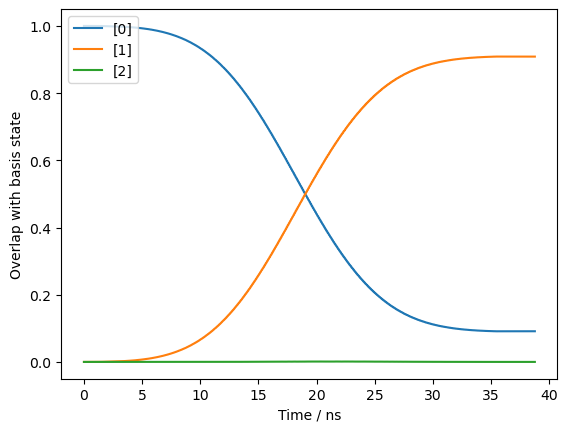

In [8]:
simulation_backend.plot_fidelity_history();

### Print out the Pulse Sequence

In [9]:
pulse_sequence

PulseSequence
DrivePulse(0, 35.55555555555556, 0.240451, 5_090_167_234.445013, 0, Drag(4, 2.43058), drive-0, 0)
ReadoutPulse(37.77777777777778, 1, 0.03, 7_301_661_824.000001, 0, Rectangular(), readout-0, 0)

### Plot the Simulated Waveform

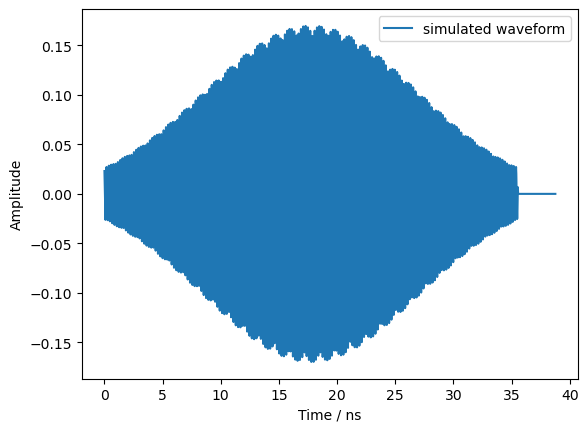

In [10]:
import matplotlib.pyplot as plt
plt.plot(channel_waveforms['time'],channel_waveforms['channels']['D-0'], label='simulated waveform')
plt.xlabel('Time / ns')
plt.ylabel('Amplitude')
plt.legend()

### Perform sampling and apply readout noise

In [11]:
ro_qubit_list = [pulse_r0.qubit]
ro_reduced_dm, rdm_qubit_list = pulse_simulator.simulation_backend.qobj_to_reduced_dm(final_state, ro_qubit_list)
samples = pulse_simulator.get_samples(1000, ro_reduced_dm, rdm_qubit_list)

ro_probability_sum: 1.0000000000000175


In [12]:
import numpy as np
from qibolab.instruments.emulator.pulse_simulator import apply_readout_noise

readout_error = {0: [0.1, 0.1], 1: [0.1, 0.1]}
noisy_samples = apply_readout_noise(samples, readout_error)
print('samples without noise: ', samples[0][:20], np.sum(noisy_samples[0]))
print('samples with noise:    ', noisy_samples[0][:20], np.sum(samples[0]))

samples without noise:  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1] 819
samples with noise:     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1] 888


## Example 2. Pulse-level Simulation of X0 Gate

### Preparation: 1. Construct qibolab backend with transpiler settings

In [13]:
# reset pulse simulator; resets readout_error to model_config values
pulse_simulator.update()
simulation_backend = pulse_simulator.simulation_backend
print('readout error: ',emulator_platform.instruments['pulse_simulator'].readout_error)
print('pulse sequence history: ', emulator_platform.instruments['pulse_simulator'].pulse_sequence_history)
print('pulse sequences simulated: ', len(emulator_platform.instruments['pulse_simulator'].simulation_backend.pulse_sim_history))

# option 1, using default transpiler
from qibolab.backends import QibolabBackend
from qibo.transpiler.pipeline import Passes

emulator_backend = QibolabBackend(platform=emulator_platform)
emulator_backend.transpiler = Passes(connectivity=emulator_backend.platform.topology)
emulator_backend.transpiler.passes = list(emulator_backend.transpiler.passes[i] for i in [0,1,3])
emulator_backend.transpiler.passes

Hilbert space structure:  ['0']
Hilbert space dimensions:  [3]
readout error:  {0: [0.01, 0.02]}
pulse sequence history:  []
pulse sequences simulated:  0


In [14]:
zerostate = simulation_backend.psi0.copy()

### Preparation: 2. Prepare test state - X0 gate

In [15]:
from qutip import Qobj
import numpy as np

# prepare test state
qibo_statevector = np.array([0.,1.])
sim_statevector = np.array([0.,1.,0.])
teststate = simulation_backend.make_arbitrary_state(sim_statevector)

# initialize with |00> state
#simulation_backend.psi0 = zerostate
# initialize with test state
simulation_backend.psi0 = teststate

print("qibo test statevector", qibo_statevector)
print(simulation_backend.psi0)

qibo test statevector [0. 1.]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]


### Preparation: 3. Construct the Circuit

In [16]:
from qibo.models import Circuit
from qibo import gates

circ_x0 = Circuit(1)
circ_x0.add(gates.X(0))
circ_x0.add(gates.M(*range(1)))
#circ_x0_job = circ_x0(nshots=1000)
circ_x0_job = circ_x0(qibo_statevector,nshots=1000)
ideal_x0_results = circ_x0_job.frequencies()

print(circ_x0.draw())
print(ideal_x0_results)
circ_x0_job.state()

[Qibo 0.2.6|INFO|2024-04-05 01:01:06]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


q0: ─X─M─
Counter({'0': 1000})


array([1.+0.j, 0.+0.j])

### Execution: Perform Pulse-level Simulation of the X0 Gate

In [17]:
#x0
backend_job = emulator_backend.execute_circuit(circ_x0, nshots=1000)

[Qibo 0.2.6|ERROR|2024-04-05 01:01:06]: x is not a native gate.
ERROR:qibo.config:x is not a native gate.
[Qibo 0.2.6|INFO|2024-04-05 01:01:06]: Connecting to instrument <qibolab.instruments.emulator.pulse_simulator.PulseSimulator object at 0x103fc2a30>.
INFO:qibo.config:Connecting to instrument <qibolab.instruments.emulator.pulse_simulator.PulseSimulator object at 0x103fc2a30>.
[Qibo 0.2.6|INFO|2024-04-05 01:01:06]: Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
INFO:qibo.config:Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
[Qibo 0.2.6|INFO|2024-04-05 01:01:06]: Minimal execution time (sequence): 0.3050488888888889
INFO:qibo.config:Minimal execution time (sequence): 0.3050488888888889


 [*********86%********   ] Elapsed 2.21s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [18]:
pulse_sequence = pulse_simulator.pulse_sequence_history[-1]
channel_waveforms = pulse_simulator.channel_waveforms_history[-1]
full_time_list = channel_waveforms['time']

psi_t_list = simulation_backend.pulse_sim_history[-1]
psi_t_list[-1]

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 9.55339031e-01-8.93319935e-16j  1.98917037e-01-2.91022796e-02j
  -5.63197517e-03+1.68065009e-03j]
 [ 1.98917037e-01+2.91022796e-02j  4.46244383e-02+8.93759337e-16j
  -1.23357885e-03+1.69105280e-04j]
 [-5.63197517e-03-1.68065009e-03j -1.23357885e-03-1.69105280e-04j
   3.65306397e-05-4.34910015e-19j]]

In [19]:
print(f'final state norm: {psi_t_list[-1].norm()}')
print(backend_job.frequencies())

final state norm: 0.9999999999999869
Counter({'0': 939, '1': 61})


[0] 0.0 0.9553390310650697
[1] 1.0 0.0446244382952545
[2] 0.0 3.653063967088187e-05


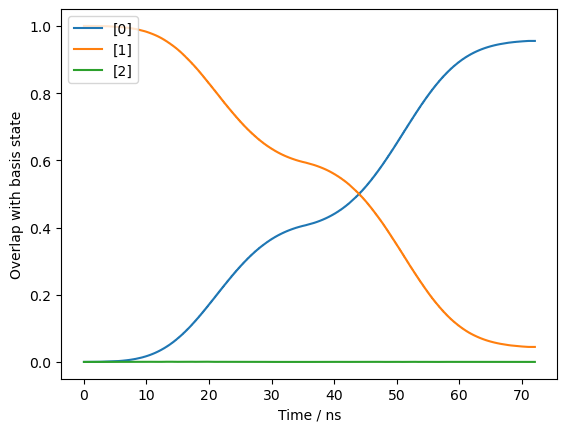

In [20]:
simulation_backend.plot_fidelity_history();

PulseSequence
DrivePulse(0, 35.55555555555556, 0.120226, 5_090_167_234.445013, 1.570796, Drag(4, 2.43058), drive-0, 0)
DrivePulse(35.55555555555556, 35.55555555555556, 0.120226, 5_090_167_234.445013, 1.570796, Drag(4, 2.43058), drive-0, 0)
ReadoutPulse(71.11111111111111, 1, 0.03, 7_301_661_824.000001, 0, Rectangular(), readout-0, 0)
number of samples: time 3245, waveform 3245


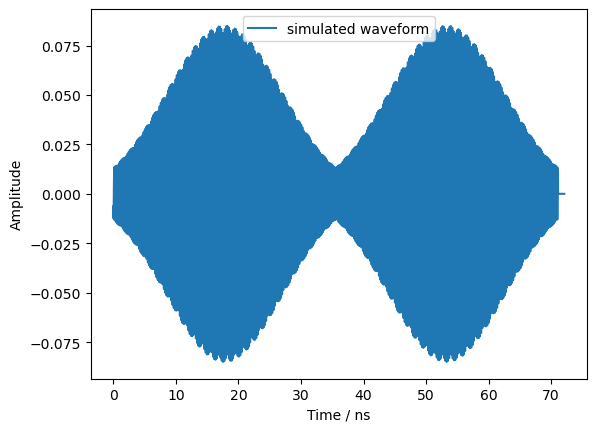

In [21]:
import matplotlib.pyplot as plt
plt.plot(channel_waveforms['time'],channel_waveforms['channels']['D-0'], label='simulated waveform')
plt.xlabel('Time / ns')
plt.ylabel('Amplitude')
plt.legend()
num_time, num_samples = channel_waveforms['time'].shape[0], channel_waveforms['channels']['D-0'].shape[0]
print(pulse_sequence)
print(f'number of samples: time {num_time}, waveform {num_samples}')

## Example 3: Sweeper

### Preparation: Construct Reference Pulse Sequence

Hilbert space structure:  ['0']
Hilbert space dimensions:  [3]
readout error:  {0: [0.01, 0.02]}
pulse sequence history:  []
pulse sequences simulated:  0


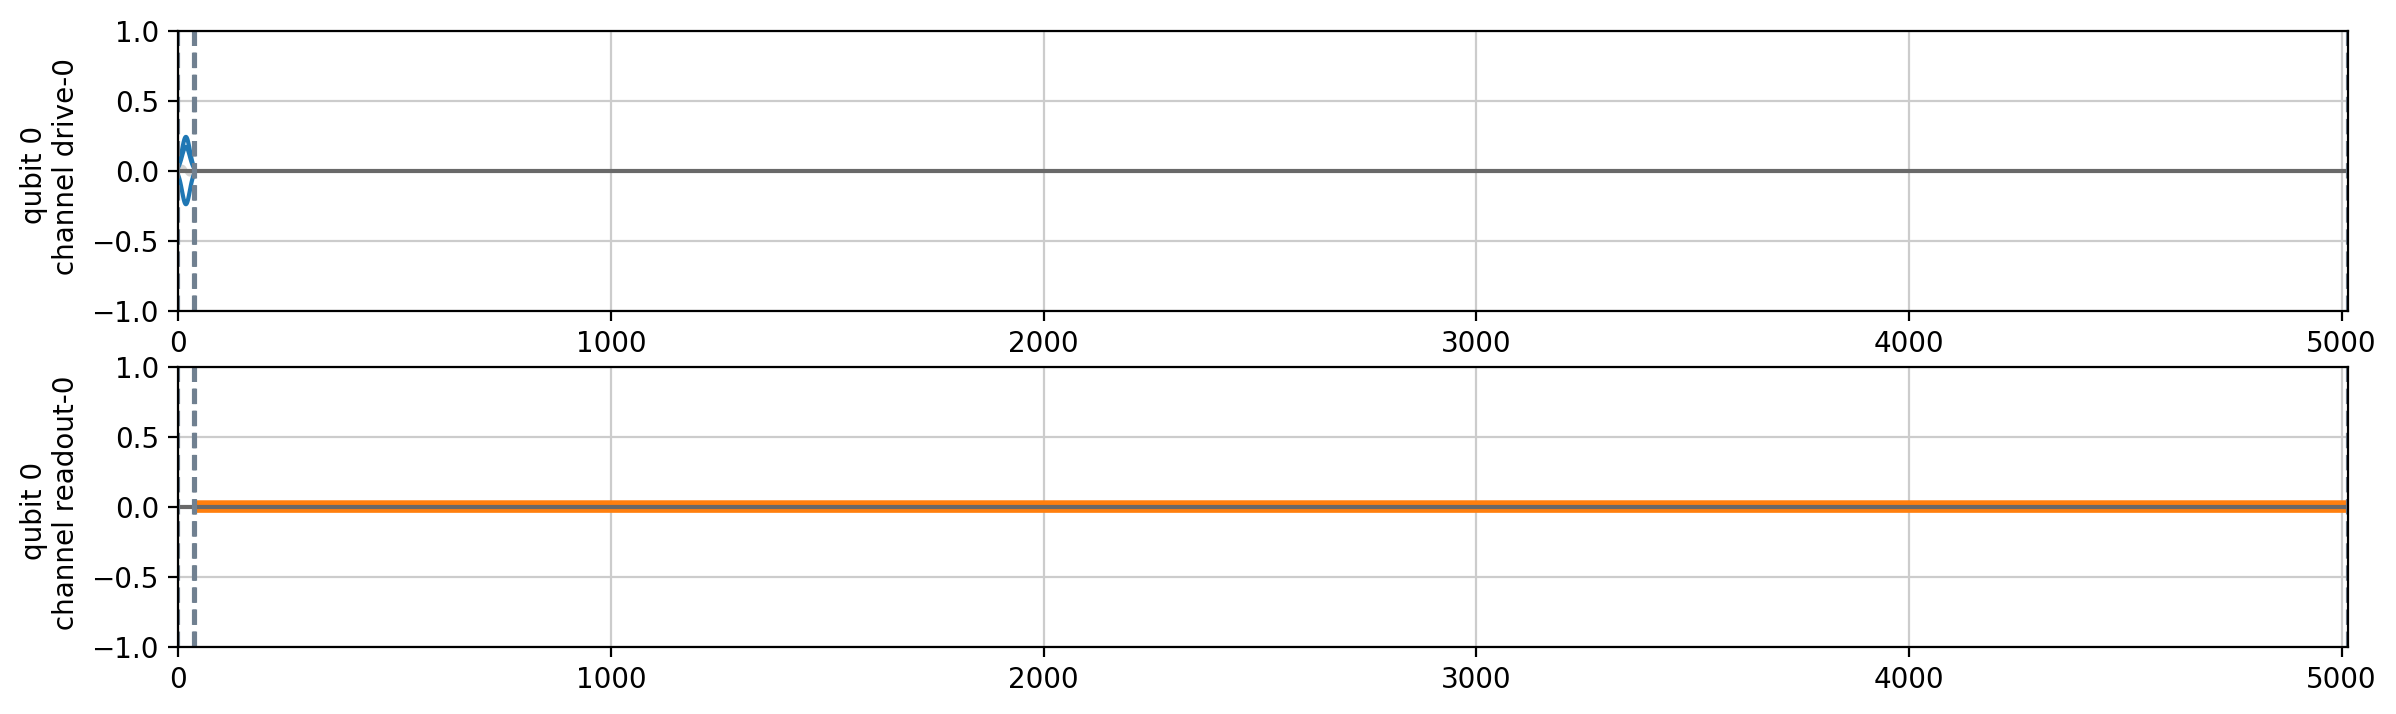

5015.555555555555
38.666666666666664
4977.777777777777


In [22]:
import numpy as np
from qibolab.pulses import PulseSequence
from qibolab import ExecutionParameters

# reset pulse simulator
pulse_simulator.update()
simulation_backend = pulse_simulator.simulation_backend
print('readout error: ',emulator_platform.instruments['pulse_simulator'].readout_error)
print('pulse sequence history: ', emulator_platform.instruments['pulse_simulator'].pulse_sequence_history)
print('pulse sequences simulated: ', len(emulator_platform.instruments['pulse_simulator'].simulation_backend.pulse_sim_history))

sequence = PulseSequence()
pulse_x0 = emulator_platform.create_RX_pulse(qubit=0, start=0)
sequence.add(pulse_x0)
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=(165/4.5+5/4.5))
sequence.add(pulse_r0)
sequence.plot()
print(sequence.duration)
print(pulse_r0.start+4/4.5)
print(pulse_r0.duration)

### Check: Simulate Reference Pulse Sequence

In [23]:
from qibolab.execution_parameters import ExecutionParameters

# Connects to lab instruments using the details specified in the calibration settings.
emulator_platform.instruments['pulse_simulator'].connect()

# Configures instruments using the loaded calibration settings.
emulator_platform.instruments['pulse_simulator'].setup()

# Turns on the local oscillators
emulator_platform.instruments['pulse_simulator'].start()

# Executes a pulse sequence.
options = ExecutionParameters(nshots=1000)
results = emulator_platform.execute_pulse_sequence(sequence, options=options)

# Turn off lab instruments
emulator_platform.instruments['pulse_simulator'].stop()

# Disconnect from the instruments
emulator_platform.instruments['pulse_simulator'].disconnect()

[Qibo 0.2.6|INFO|2024-04-05 01:01:09]: Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
INFO:qibo.config:Connecting to ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
[Qibo 0.2.6|INFO|2024-04-05 01:01:09]: Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
INFO:qibo.config:Setting up ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
[Qibo 0.2.6|INFO|2024-04-05 01:01:09]: Starting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
INFO:qibo.config:Starting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
[Qibo 0.2.6|INFO|2024-04-05 01:01:09]: Minimal execution time (sequence): 0.3050155555555556
INFO:qibo.config:Minimal execution time (sequence): 0.3050155555555556


 [********100%***********] Elapsed 1.46s / Remaining 00:00:00:00[*********81%*******    ] Elapsed 1.18s / Remaining 00:00:00:00

[Qibo 0.2.6|INFO|2024-04-05 01:01:10]: Stopping ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.


 Total run time:   1.46s
simulation time 1.464871959
ro_probability_sum: 1.0000000000000175


INFO:qibo.config:Stopping ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
[Qibo 0.2.6|INFO|2024-04-05 01:01:10]: Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.
INFO:qibo.config:Disconnecting ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip backend.


[0] 1.0 0.0912788264764749
[1] 0.0 0.9086761290254555
[2] 0.0 4.504449808724775e-05


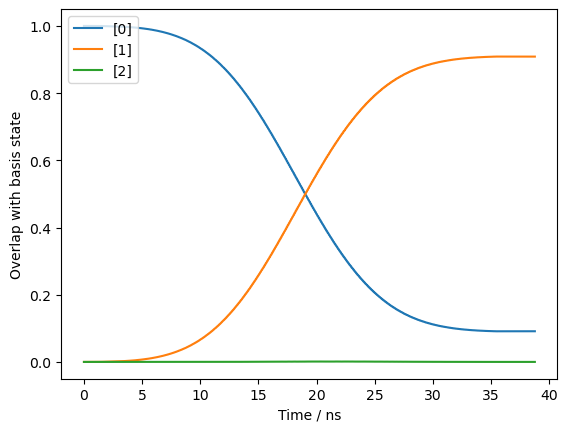

In [24]:
emulator_platform.instruments['pulse_simulator'].simulation_backend.plot_fidelity_history();

In [25]:
from qibolab.sweeper import Sweeper, Parameter

parameter = Parameter.duration
parameter2 = Parameter.amplitude
parameter_range = np.linspace(155/4.5, 165/4.5, num=3)
parameter2_range = np.linspace(0.23045125169257026, 0.25045125169257026, num=3)
sweeper = Sweeper(parameter, parameter_range, [pulse_x0])
sweeper2 = Sweeper(parameter2, parameter2_range, [pulse_x0])
'''
parameter_range = np.linspace(-5/4.5, 5/4.5, num=3)
parameter2_range = np.linspace(-0.01, 0.01, num=3)
sweeper = Sweeper(parameter, parameter_range, [pulse_x0], type=SweeperType.OFFSET)
sweeper2 = Sweeper(parameter2, parameter2_range, [pulse_x0], type=SweeperType.OFFSET)
'''
print(sweeper)
print(sweeper2)

Sweeper(parameter=<Parameter.duration: 3>, values=array([34.44444444, 35.55555556, 36.66666667]), pulses=[DrivePulse(0, 35.55555555555556, 0.240451, 5_090_167_234.445013, 0, Drag(4, 2.43058), drive-0, 0)], qubits=None, couplers=None, type=<SweeperType.ABSOLUTE: functools.partial(<function SweeperType.<lambda> at 0x151681040>)>)
Sweeper(parameter=<Parameter.amplitude: 2>, values=array([0.23045125, 0.24045125, 0.25045125]), pulses=[DrivePulse(0, 35.55555555555556, 0.240451, 5_090_167_234.445013, 0, Drag(4, 2.43058), drive-0, 0)], qubits=None, couplers=None, type=<SweeperType.ABSOLUTE: functools.partial(<function SweeperType.<lambda> at 0x151681040>)>)


In [26]:
sweep_results = emulator_platform.sweep(sequence, ExecutionParameters(), sweeper, sweeper2)

[Qibo 0.2.6|INFO|2024-04-05 01:01:10]: Minimal execution time (sweep): 11.060629503999998
INFO:qibo.config:Minimal execution time (sweep): 11.060629503999998


sweep param: duration
values [34.44444444 35.55555556 36.66666667]
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 Total run time:   1.40s*] Elapsed 1.40s / Remaining 00:00:00:00
simulation time 1.3991302920000006
ro_probability_sum: 1.0000000000000142
 [*********57%*          ] Elapsed 0.99s / Remaining 00:00:00:00[*********47%           ] Elapsed 0.82s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.18s*] Elapsed 1.18s / Remaining 00:00:00:00[*********73%*****      ] Elapsed 0.83s / Remaining 00:00:00:00
simulation time 1.1868230420000003
ro_probability_sum: 1.0000000000000038
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 Total run time:   1.43s*] Elapsed 1.43s / Remaining 00:00:00:00
simulation time 1.4282749589999995
ro_probability_sum: 1.0
 [***      11%           ] Elapsed 0.12s / Remaining 00:00:00:01

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.27s*] Elapsed 1.27s / Remaining 00:00:00:00
simulation time 1.2696826659999996
ro_probability_sum: 1.0000000000000056
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 [*********76%*****      ] Elapsed 1.49s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.45s*] Elapsed 1.45s / Remaining 00:00:00:00
simulation time 1.4536650830000006
ro_probability_sum: 1.0000000000000195
 [*********82%*******    ] Elapsed 1.19s / Remaining 00:00:00:00[*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [27]:
sweep_results[0].probability(1)

array([[0.88549805, 0.89135742, 0.88037109],
       [0.88061523, 0.88745117, 0.88745117],
       [0.89111328, 0.88330078, 0.88793945]])

In [28]:
pulse_sequence_history = emulator_platform.instruments['pulse_simulator'].pulse_sequence_history
print('Number of pulse sequences simulated: ', len(pulse_sequence_history))
print(pulse_sequence_history[0]==pulse_sequence_history[5])
print(pulse_sequence_history[0]==pulse_sequence_history[4])

Number of pulse sequences simulated:  10
True
False


In [29]:
pulse_sim_history = emulator_platform.instruments['pulse_simulator'].simulation_backend.pulse_sim_history
print('simulation runs: ', len(pulse_sim_history))
print(pulse_sim_history[0]==pulse_sim_history[5])
print(pulse_sim_history[0]==pulse_sim_history[4])

simulation runs:  10
True
False


[0] 1.0 0.10756892954143304
[1] 0.0 0.8923904621645712
[2] 0.0 4.0608293995774775e-05
[0] 1.0 0.0912788264764749
[1] 0.0 0.9086761290254555
[2] 0.0 4.504449808724775e-05
[0] 1.0 0.08151669906874849
[1] 0.0 0.9184338921371294
[2] 0.0 4.9408794127710624e-05


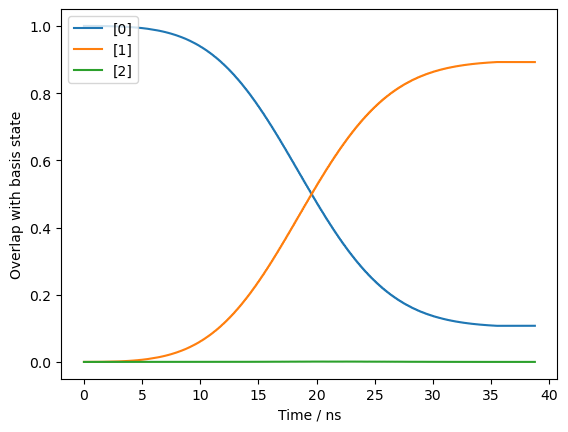

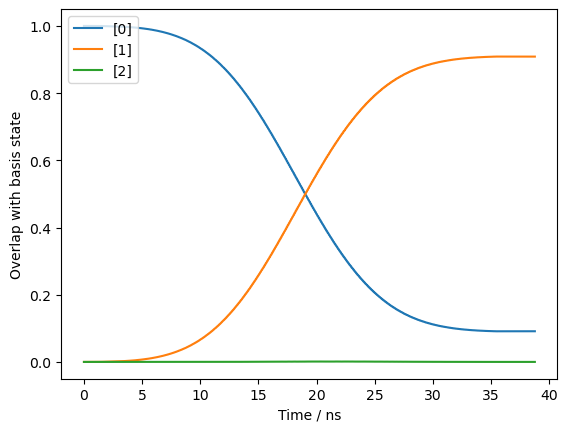

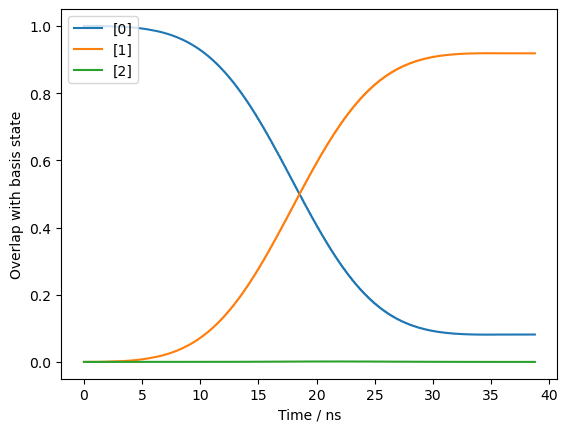

In [30]:
emulator_platform.instruments['pulse_simulator'].simulation_backend.plot_fidelity_history(sim_index=4);
emulator_platform.instruments['pulse_simulator'].simulation_backend.plot_fidelity_history(sim_index=5);
emulator_platform.instruments['pulse_simulator'].simulation_backend.plot_fidelity_history(sim_index=6);

## --- Version information for major packages used in the current Qibolab emulator example ---

In [ ]:
%load_ext watermark

In [47]:
%watermark -v -p qibolab,qibo,qutip,matplotlib,numpy

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

qibolab   : 0.1.6
qibo      : 0.2.4
qutip     : 4.7.4
matplotlib: 3.8.2
numpy     : 1.24.4

